In [45]:
import gym
from gym import spaces
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from typing import Dict, Tuple, List, Any

In [46]:
import networkx as nx

# Delivery Modes
MODES = {
    "flight": {"cost_per_km": 0.12, "hours_per_km": 1.0/750},  # ~750 km/h
    "train":  {"cost_per_km": 0.06, "hours_per_km": 1.0/120},  # ~120 km/h
    "truck":  {"cost_per_km": 0.08, "hours_per_km": 1.0/80},   # ~80 km/h
    "ship":   {"cost_per_km": 0.04, "hours_per_km": 1.0/35},   # ~35 km/h
}

City = str
Mode = str
State = Tuple[City, City]         # (current_city, goal_city)
Action = Tuple[City, Mode]
mode_list = list(MODES.keys())

# Define coastal cities (used for ship delivery)
COASTAL_CITIES = {
    "New York", "San Francisco", "Los Angeles", "Miami", "Seattle",
    "Boston", "Houston", "San Diego", "Philadelphia", "Charlotte", "Orlando"
}

# City graph
G = nx.Graph()

cities = [
    "New York", "Chicago", "Denver", "San Francisco", "Los Angeles",
    "Houston", "Miami", "Atlanta", "Seattle", "Boston",
    "Dallas", "Phoenix", "Las Vegas", "Philadelphia", "Detroit",
    "Minneapolis", "St. Louis", "Charlotte", "San Diego", "Orlando"
]

# Function to add edge with realistic modes
def add_realistic_edge(G, city1, city2, distance, coastal_cities):
    # Default modes
    modes = ["truck", "train", "flight"]

    # Add ship only if both cities are coastal
    if city1 in coastal_cities and city2 in coastal_cities:
        modes.append("ship")

    G.add_edge(city1, city2, distance=distance, modes=modes)

# Edges with distances
edges = [
    ("New York", "Chicago", 1145),
    ("Chicago", "Denver", 1610),
    ("Denver", "San Francisco", 1930),
    ("San Francisco", "Los Angeles", 610),
    ("Los Angeles", "Houston", 2225),
    ("Houston", "Miami", 1900),
    ("Miami", "Atlanta", 1060),
    ("Atlanta", "New York", 1390),
    ("Seattle", "San Francisco", 1300),
    ("Seattle", "Denver", 2170),
    ("Boston", "New York", 345),
    ("Chicago", "Atlanta", 960),
    ("Chicago", "Houston", 1510),
    ("Denver", "Houston", 1415),
    ("Atlanta", "Houston", 1280),
    ("New York", "Miami", 2050),
    ("Boston", "Chicago", 1360),
    ("Boston", "Atlanta", 1500),
    ("Seattle", "Chicago", 2780),
    ("Los Angeles", "Denver", 1605),
    ("Los Angeles", "Miami", 3750),
    ("Dallas", "Houston", 385),
    ("Dallas", "Atlanta", 1170),
    ("Dallas", "Denver", 1250),
    ("Phoenix", "Los Angeles", 590),
    ("Phoenix", "Denver", 1300),
    ("Las Vegas", "Los Angeles", 435),
    ("Las Vegas", "Phoenix", 480),
    ("Philadelphia", "New York", 150),
    ("Philadelphia", "Boston", 490),
    ("Detroit", "Chicago", 455),
    ("Detroit", "Boston", 1120),
    ("Minneapolis", "Chicago", 660),
    ("Minneapolis", "Denver", 1450),
    ("St. Louis", "Chicago", 480),
    ("St. Louis", "Dallas", 1040),
    ("Charlotte", "Atlanta", 400),
    ("Charlotte", "Philadelphia", 860),
    ("San Diego", "Los Angeles", 195),
    ("San Diego", "Phoenix", 570),
    ("Orlando", "Miami", 380),
    ("Orlando", "Atlanta", 720)
]

# Add all edges using the function
for u, v, dist in edges:
    add_realistic_edge(G, u, v, dist, COASTAL_CITIES)



In [47]:
print(G)

Graph with 20 nodes and 42 edges


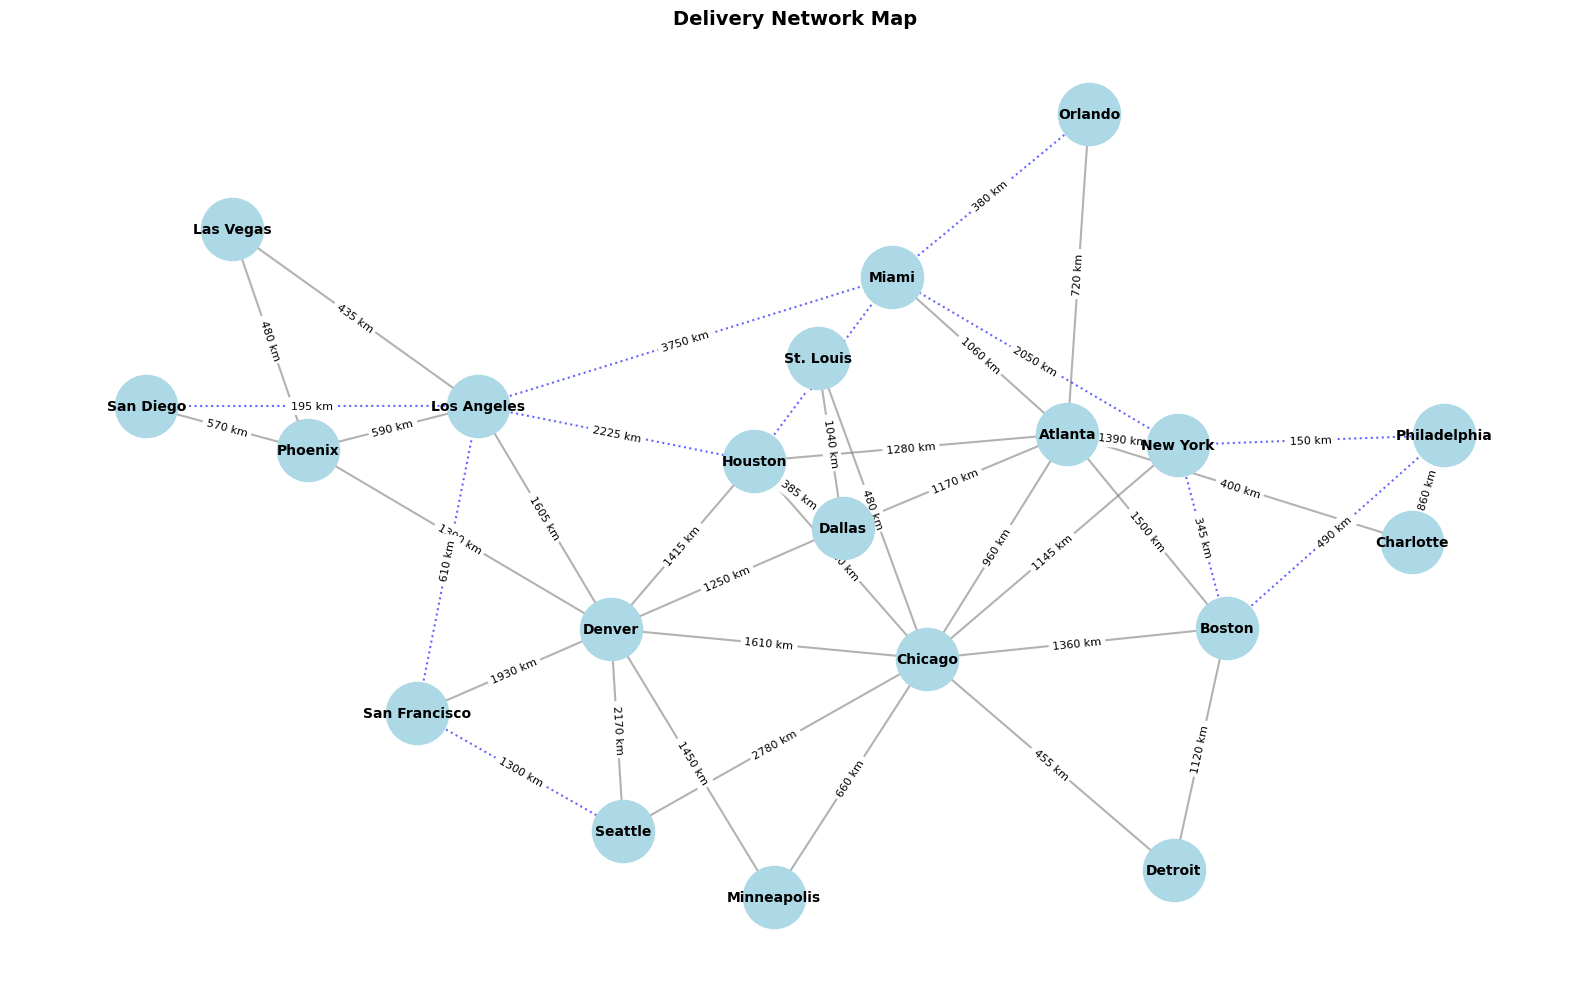

In [48]:
def visualize_plain_graph(graph):
    """Plain visualization of the delivery network map with ship routes dotted in blue."""
    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(graph, seed=42)

    # Draw nodes (all same color)
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight='bold')

    # Separate edges into ship and non-ship
    ship_edges = []
    non_ship_edges = []
    for u, v, data in graph.edges(data=True):
        if 'ship' in data['modes']:
            ship_edges.append((u, v))
        else:
            non_ship_edges.append((u, v))

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edgelist=non_ship_edges, width=1.5, alpha=0.6, edge_color='gray')
    nx.draw_networkx_edges(graph, pos, edgelist=ship_edges, style='dotted', width=1.5, alpha=0.6, edge_color='blue')

    # Add edge labels for distance
    edge_labels = {(u, v): f"{d['distance']} km" for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Title
    plt.title("Delivery Network Map", fontsize=14, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_plain_graph(G)


In [49]:
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"{u} -> {v} | Distance: {data['distance']} km | Modes: {data['modes']}")


New York -> Chicago | Distance: 1145 km | Modes: ['truck', 'train', 'flight']
New York -> Atlanta | Distance: 1390 km | Modes: ['truck', 'train', 'flight']
New York -> Boston | Distance: 345 km | Modes: ['truck', 'train', 'flight', 'ship']
New York -> Miami | Distance: 2050 km | Modes: ['truck', 'train', 'flight', 'ship']
New York -> Philadelphia | Distance: 150 km | Modes: ['truck', 'train', 'flight', 'ship']


In [50]:
def calculate_reward(cost, time, current_city, goal_city, prev_city, steps, max_steps,
                    path_cities, total_time, graph, cost_weight=1.0, time_weight=1.0):
    """Calculate reward that strongly encourages goal completion and prevents loops."""

    if current_city == goal_city:
        # GOAL REACHED - Massive positive reward
        base_goal_reward = 5000

        # Efficiency bonuses
        cost_efficiency = max(0, (800 - cost) / 10)
        time_efficiency = max(0, (50 - total_time) * 2)

        # Step efficiency bonus
        if steps <= 5:
            step_bonus = 2000
        elif steps <= 8:
            step_bonus = 1500
        elif steps <= 12:
            step_bonus = 1000
        else:
            step_bonus = 500

        total_reward = base_goal_reward + cost_efficiency + time_efficiency + step_bonus
        return total_reward

    else:
        # INTERMEDIATE STEPS - Strong penalties for loops
        base_step_reward = 100

        # STRICT loop prevention - heavy penalties for revisiting cities
        city_visit_count = path_cities.count(current_city)
        if city_visit_count > 1:
            loop_penalty = (city_visit_count - 1) * 1000  # Exponentially increasing penalty
            return -loop_penalty

        # Distance progress reward
        try:
            prev_distance = nx.shortest_path_length(graph, prev_city, goal_city, weight='distance')
            current_distance = nx.shortest_path_length(graph, current_city, goal_city, weight='distance')

            distance_improvement = prev_distance - current_distance
            if distance_improvement > 0:
                progress_reward = distance_improvement * 0.5
            else:
                progress_reward = -50  # Small penalty for not making progress

        except:
            progress_reward = 0

        # Cost/time penalties
        cost_penalty = cost * 0.01
        time_penalty = time * 0.1

        step_reward = base_step_reward + progress_reward - cost_penalty - time_penalty
        return max(step_reward, -100)  # Minimum reward floor


In [51]:
class RouteEnv:
    def __init__(
        self,
        graph,
        max_steps: int = 25,  # Reduced max steps to force efficient routes
        time_weight: float = 1.0,
        cost_weight: float = 1.0,
        invalid_penalty: float = 1000.0,
    ):
        self.graph = graph
        self.max_steps = max_steps
        self.time_weight = time_weight
        self.cost_weight = cost_weight
        self.invalid_penalty = invalid_penalty
        self._cur = None
        self._goal = None
        self._steps = 0
        self._path_cities = []
        self._total_time = 0.0

    def reset(self, start: City, goal: City) -> State:
        self._cur = start
        self._goal = goal
        self._steps = 0
        self._path_cities = [start]
        self._total_time = 0.0
        return (self._cur, self._goal)

    def neighbors(self, city: City) -> List[Action]:
        """Get valid neighboring actions, excluding already visited cities to prevent loops."""
        nbrs: List[Action] = []
        if city in self.graph:
            for nxt in self.graph[city]:
                # CRITICAL FIX: Don't allow revisiting cities (except goal)
                if nxt in self._path_cities and nxt != self._goal:
                    continue

                meta = self.graph[city][nxt]
                for m in meta["modes"]:
                    nbrs.append((nxt, m))
        return nbrs

    def edge_cost_time(self, cur: City, nxt: City, mode: Mode) -> Tuple[float, float]:
        meta = self.graph[cur][nxt]
        dist = meta["distance"]
        spec = MODES[mode]
        cost = dist * spec["cost_per_km"]
        hours = dist * spec["hours_per_km"]
        return cost, hours

    def step(self, action: Action) -> Tuple[State, float, bool, Dict[str, Any]]:
        assert self._cur is not None and self._goal is not None, "Call reset() first"
        self._steps += 1

        nxt, mode = action
        info: Dict[str, Any] = {"mode": mode}

        # Validate action
        if (self._cur not in self.graph or
            nxt not in self.graph[self._cur] or
            mode not in self.graph[self._cur][nxt]["modes"]):
            reward = -self.invalid_penalty
            done = True
            return (self._cur, self._goal), reward, done, info

        # CRITICAL: Prevent loops - don't allow revisiting cities (except goal)
        if nxt in self._path_cities and nxt != self._goal:
            reward = -2000  # Heavy penalty for trying to revisit
            done = True
            return (self._cur, self._goal), reward, done, info

        # Compute cost/time and reward
        cost, hours = self.edge_cost_time(self._cur, nxt, mode)
        info.update({"cost": cost, "time": hours})

        prev_city = self._cur
        self._cur = nxt
        self._path_cities.append(self._cur)
        self._total_time += hours

        goal_reached = (self._cur == self._goal)
        done = goal_reached or (self._steps >= self.max_steps)

        reward = calculate_reward(
            cost=cost,
            time=hours,
            current_city=self._cur,
            goal_city=self._goal,
            prev_city=prev_city,
            steps=self._steps,
            max_steps=self.max_steps,
            path_cities=self._path_cities,
            total_time=self._total_time,
            graph=self.graph,
            cost_weight=self.cost_weight,
            time_weight=self.time_weight
        )

        next_state: State = (self._cur, self._goal)
        return next_state, reward, done, info


In [52]:
class ImprovedQAgent:
    def __init__(
        self,
        env: RouteEnv,
        alpha: float = 0.1,
        gamma: float = 0.95,
        epsilon_start: float = 0.9,
        epsilon_min: float = 0.05,
        epsilon_decay: float = 0.9995,
    ):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.Q: Dict[Tuple[State, Action], float] = defaultdict(float)

    def choose_action(self, state: State) -> Action:
        cur, goal = state
        actions = self.env.neighbors(cur)

        # If no valid actions (shouldn't happen with proper graph), return dummy
        if not actions:
            return (cur, "truck")

        # ε-greedy exploration
        if random.random() < self.epsilon:
            return random.choice(actions)

        # Greedy by Q-value with intelligent tie-breaking
        q_values = [(a, self.Q[(state, a)]) for a in actions]
        max_q = max(q for _, q in q_values)
        best_actions = [a for a, q in q_values if q == max_q]

        # Tie-breaking: choose action that gets closest to goal
        if len(best_actions) > 1:
            def distance_to_goal(action):
                next_city = action[0]
                try:
                    return nx.shortest_path_length(self.env.graph, next_city, goal, weight='distance')
                except:
                    return float('inf')

            best_actions.sort(key=distance_to_goal)

        return best_actions[0]

    def update(self, state: State, action: Action, reward: float, next_state: State):
        next_actions = self.env.neighbors(next_state[0])
        max_next = 0.0 if not next_actions else max(self.Q[(next_state, a)] for a in next_actions)
        key = (state, action)
        target = reward + self.gamma * max_next
        self.Q[key] += self.alpha * (target - self.Q[key])

    def decay(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def get_best_path(self, start: City, goal: City, max_hops: int = 25) -> Tuple[List[Tuple[City, Mode]], float, float]:
        """Get the best path using learned Q-values with fallback to shortest path."""
        if start == goal:
            return [(start, "")], 0.0, 0.0

        path: List[Tuple[City, Mode]] = []
        cur = start
        total_cost = 0.0
        total_time = 0.0
        visited = {start}

        for hop in range(max_hops):
            if cur == goal:
                break

            # Get valid actions (excluding already visited cities)
            all_neighbors = []
            if cur in self.env.graph:
                for nxt in self.env.graph[cur]:
                    if nxt not in visited or nxt == goal:  # Allow goal even if visited
                        meta = self.env.graph[cur][nxt]
                        for mode in meta["modes"]:
                            all_neighbors.append((nxt, mode))

            if not all_neighbors:
                # No valid moves - path failed
                break

            state: State = (cur, goal)

            # Check if we have learned Q-values for this state
            q_values = [(a, self.Q[(state, a)]) for a in all_neighbors]
            max_q = max(q for _, q in q_values)

            if max_q > 0:
                # Use learned Q-values
                best_actions = [a for a, q in q_values if q == max_q]

                # Tie-break by distance to goal
                def distance_score(action):
                    next_city = action[0]
                    try:
                        return nx.shortest_path_length(self.env.graph, next_city, goal, weight='distance')
                    except:
                        return float('inf')

                action = min(best_actions, key=distance_score)
            else:
                # Fallback: use shortest path guidance
                try:
                    shortest_path = nx.shortest_path(self.env.graph, cur, goal, weight='distance')
                    if len(shortest_path) > 1:
                        next_city = shortest_path[1]
                        # Find cheapest mode to next city on shortest path
                        valid_to_next = [a for a in all_neighbors if a[0] == next_city]
                        if valid_to_next:
                            def mode_cost(action):
                                _, mode = action
                                c, t = self.env.edge_cost_time(cur, next_city, mode)
                                return c + t * 0.1  # Slight preference for faster modes
                            action = min(valid_to_next, key=mode_cost)
                        else:
                            # Next city on shortest path not available, choose closest available
                            def fallback_score(action):
                                next_city_alt, _ = action
                                try:
                                    return nx.shortest_path_length(self.env.graph, next_city_alt, goal, weight='distance')
                                except:
                                    return float('inf')
                            action = min(all_neighbors, key=fallback_score)
                    else:
                        action = random.choice(all_neighbors)
                except:
                    # Final fallback
                    def final_distance_score(action):
                        next_city, _ = action
                        try:
                            return nx.shortest_path_length(self.env.graph, next_city, goal, weight='distance')
                        except:
                            return float('inf')
                    action = min(all_neighbors, key=final_distance_score)

            # Execute action
            nxt, mode = action
            cost, hours = self.env.edge_cost_time(cur, nxt, mode)
            total_cost += cost
            total_time += hours
            path.append((cur, mode))
            cur = nxt
            visited.add(cur)

        # Add final destination
        path.append((cur, ""))
        return path, total_cost, total_time


In [53]:
def plot_training_progress(episode_rewards, window_size=100):
    """Plot the training progress."""
    plt.figure(figsize=(12, 8))

    # Plot episode rewards
    plt.plot(episode_rewards, alpha=0.3, color='blue', label='Episode Rewards')

    # Plot moving average
    if len(episode_rewards) >= window_size:
        moving_avg = [np.mean(episode_rewards[max(0, i-window_size):i+1])
                     for i in range(window_size-1, len(episode_rewards))]
        plt.plot(range(window_size-1, len(episode_rewards)), moving_avg,
                color='red', linewidth=2, label=f'Moving Average ({window_size} episodes)')

    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Total Reward', fontsize=12)
    plt.title('Training Progress - Reward vs Episode', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)

    # Add statistics text box
    if episode_rewards:
        recent_avg = np.mean(episode_rewards[-min(1000, len(episode_rewards)):])
        max_reward = max(episode_rewards)
        min_reward = min(episode_rewards)

        stats_text = f'Recent Avg: {recent_avg:.1f}\nMax: {max_reward:.1f}\nMin: {min_reward:.1f}'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()


Running fixed version without loops...
STARTING FIXED TRAINING (No More Loops!)
Episodes: 20,000
Print every: 2,000 episodes
Cities: 20

EPISODE 2,000 / 20,000
Epsilon: 0.3310
TESTING 8 RANDOM ROUTES:
  1. St. Louis → Houston (SUCCESS)
     Route: St. Louis(truck) → Chicago(truck) → Houston
     Cost: $159 | Time: 24.9h | Reward: 7114.3 | Steps: 2
  2. Boston → Los Angeles (SUCCESS)
     Route: Boston(flight) → Chicago(truck) → Denver(truck) → Los Angeles
     Cost: $420 | Time: 42.0h | Reward: 7054.0 | Steps: 3
  3. San Francisco → Charlotte (SUCCESS)
     Route: San Francisco(flight) → Los Angeles(flight) → Miami(flight) → Atlanta(flight) → Charlotte
     Cost: $698 | Time: 7.8h | Reward: 7094.6 | Steps: 4
  4. Atlanta → St. Louis (SUCCESS)
     Route: Atlanta(truck) → Houston(truck) → Dallas(flight) → St. Louis
     Cost: $258 | Time: 22.2h | Reward: 7109.8 | Steps: 3
  5. Dallas → Seattle (SUCCESS)
     Route: Dallas(train) → Denver(truck) → Seattle
     Cost: $249 | Time: 37.5h | 

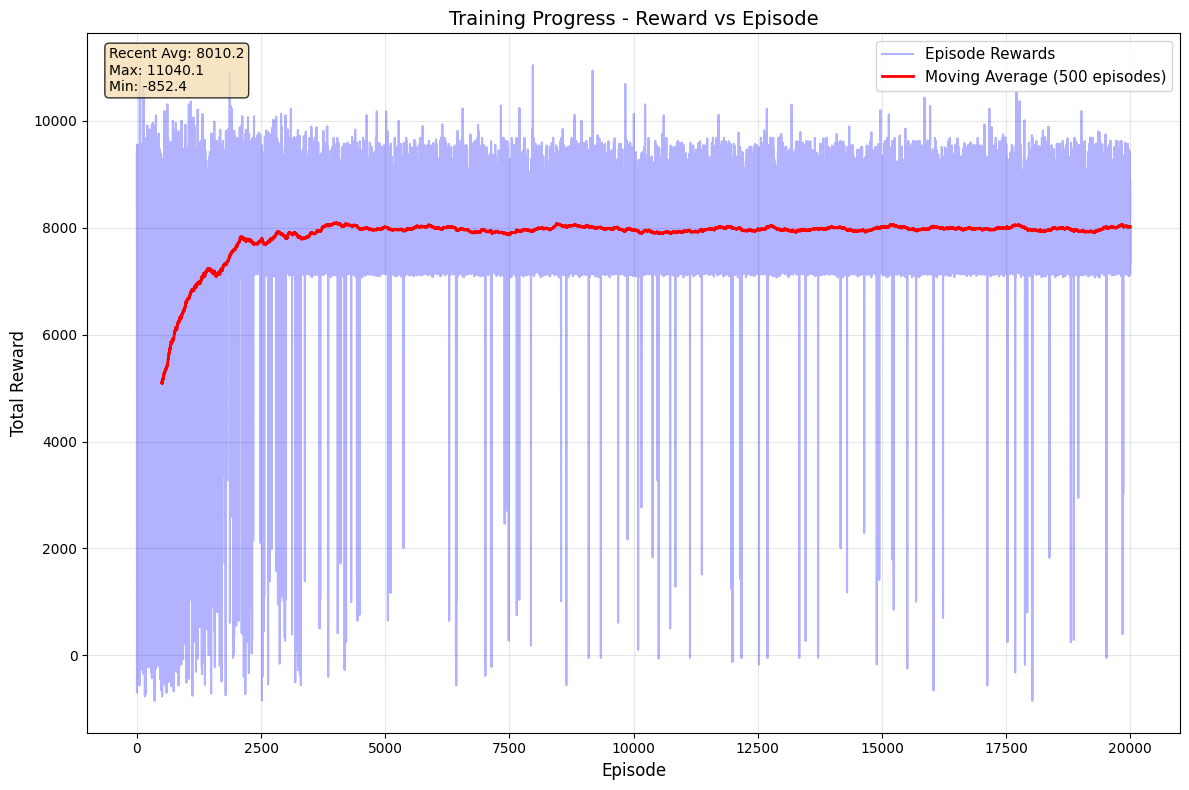

In [54]:
def train_fixed(
    num_episodes,
    print_interval,
    cities_list,
    seed=None
):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"STARTING FIXED TRAINING (No More Loops!)")
    print(f"Episodes: {num_episodes:,}")
    print(f"Print every: {print_interval:,} episodes")
    print(f"Cities: {len(cities_list)}")
    print("="*60)

    env = RouteEnv(G)
    agent = ImprovedQAgent(env)
    episode_rewards = []

    for ep in range(1, num_episodes + 1):
        # Random start/goal selection
        start_city = random.choice(cities_list)
        goal_city = random.choice(cities_list)
        while goal_city == start_city:
            goal_city = random.choice(cities_list)

        state = env.reset(start_city, goal_city)
        total_reward = 0.0

        for _ in range(env.max_steps):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            total_reward += reward
            state = next_state
            if done:
                break

        agent.decay()
        episode_rewards.append(total_reward)

        if ep % print_interval == 0:
            print(f"\nEPISODE {ep:,} / {num_episodes:,}")
            print(f"Epsilon: {agent.epsilon:.4f}")

            # Test routes
            test_pairs = []
            for _ in range(10):
                s, g = random.choice(cities_list), random.choice(cities_list)
                if s != g:
                    test_pairs.append((s, g))
            test_pairs = test_pairs[:8]

            completed = 0
            print(f"TESTING {len(test_pairs)} RANDOM ROUTES:")

            for i, (start, goal) in enumerate(test_pairs, 1):
                path, cost, time = agent.get_best_path(start, goal)
                final_city = path[-1][0] if path else start

                # Calculate the actual reward for this specific route using your reward function
                if final_city == goal:
                    completed += 1
                    status = "(SUCCESS)"
                    # Calculate goal completion reward
                    path_cities = [city for city, mode in path]
                    route_reward = calculate_reward(
                        cost=cost,
                        time=time,
                        current_city=final_city,
                        goal_city=goal,
                        prev_city=path[-2][0] if len(path) > 1 else start,
                        steps=len(path)-1,
                        max_steps=env.max_steps,
                        path_cities=path_cities,
                        total_time=time,
                        graph=G
                    )
                else:
                    status = "(FAILED)"
                    # Calculate incomplete route reward (negative)
                    path_cities = [city for city, mode in path]
                    route_reward = calculate_reward(
                        cost=cost,
                        time=time,
                        current_city=final_city,
                        goal_city=goal,
                        prev_city=path[-2][0] if len(path) > 1 else start,
                        steps=len(path)-1,
                        max_steps=env.max_steps,
                        path_cities=path_cities,
                        total_time=time,
                        graph=G
                    )

                # Build route string - limit to reasonable length
                route_parts = []
                for j, (city, mode) in enumerate(path[:8]):  # Show max 8 steps
                    if j == len(path) - 1:  # Last city (destination)
                        route_parts.append(city)
                    else:
                        route_parts.append(f"{city}({mode})")

                if len(path) > 8:
                    route_parts.append("...")
                    route_parts.append(path[-1][0])

                route_str = " → ".join(route_parts)

                print(f"  {i}. {start} → {goal} {status}")
                print(f"     Route: {route_str}")
                print(f"     Cost: ${cost:.0f} | Time: {time:.1f}h | Reward: {route_reward:.1f} | Steps: {len(path)-1}")

            completion_rate = (completed / len(test_pairs)) * 100 if test_pairs else 0
            print(f"COMPLETION RATE: {completed}/{len(test_pairs)} ({completion_rate:.1f}%)")
            print("="*60)

    # Final summary
    print(f"\nTRAINING COMPLETE!")

    return agent, env, episode_rewards


# Test function
def quick_test_fixed():
    return train_fixed(
        num_episodes=20000,
        print_interval=2000,
        cities_list=cities,
        seed=42
    )

if __name__ == "__main__":
    # Run the fixed version
    print("Running fixed version without loops...")
    agent, env, rewards = quick_test_fixed()

    # Plot results
    plot_training_progress(rewards, window_size=500)

In [55]:
def visualize_graph_with_rl_route(graph, rl_path_cities=None, start_city=None, goal_city=None):
    """Enhanced visualization showing RL agent's recommended route in red."""
    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(graph, seed=42)

    # Draw all nodes
    node_colors = []
    for node in graph.nodes():
        if node == start_city:
            node_colors.append('green')  # Start city in green
        elif node == goal_city:
            node_colors.append('red')    # Goal city in red
        elif rl_path_cities and node in rl_path_cities:
            node_colors.append('orange') # RL path cities in orange
        else:
            node_colors.append('lightblue')  # Other cities

    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_color=node_colors)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight='bold')

    # Separate edges by type
    rl_edges = []
    ship_edges = []
    non_ship_edges = []

    # Get RL route edges if path provided
    if rl_path_cities and len(rl_path_cities) > 1:
        for i in range(len(rl_path_cities) - 1):
            city1, city2 = rl_path_cities[i], rl_path_cities[i + 1]
            if graph.has_edge(city1, city2):
                rl_edges.append((city1, city2))

    # Categorize all edges
    for u, v, data in graph.edges(data=True):
        edge = (u, v)
        if edge in rl_edges or (v, u) in rl_edges:
            continue  # Skip RL edges for now, will draw them separately
        elif 'ship' in data['modes']:
            ship_edges.append(edge)
        else:
            non_ship_edges.append(edge)

    # Draw regular edges
    nx.draw_networkx_edges(graph, pos, edgelist=non_ship_edges, width=1, alpha=0.6, edge_color='gray')
    nx.draw_networkx_edges(graph, pos, edgelist=ship_edges, style='dotted', width=1, alpha=0.6, edge_color='blue')

    # Draw RL route edges in RED with thick lines
    if rl_edges:
        nx.draw_networkx_edges(graph, pos, edgelist=rl_edges, width=4, edge_color='red', alpha=0.8)

    # Add edge labels for distance
    edge_labels = {(u, v): f"{d['distance']} km" for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Create legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Start City'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Goal City'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='RL Path Cities'),
        plt.Line2D([0], [0], color='red', linewidth=4, label='RL Agent Route'),
        plt.Line2D([0], [0], color='gray', linewidth=1, label='Other Routes'),
        plt.Line2D([0], [0], color='blue', linewidth=1, linestyle=':', label='Ship Routes')
    ]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

    title = "Delivery Network Map"
    if start_city and goal_city:
        title += f" - RL Route: {start_city} → {goal_city}"
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

ROUTE ANALYSIS: San Diego → Philadelphia
Found 17159 possible paths


TOP 5 ROUTES (CHEAPEST optimization):
--------------------------------------------------------------------------------

 1. San Diego → Los Angeles → Houston → Atlanta → Charlotte → Philadelphia
    Cost: $ 232.00 | Time: 107.71h | Hops: 5
    Segments:
            San Diego →     Los Angeles [  ship]  195km $  7.80  5.57h
          Los Angeles →         Houston [  ship] 2225km $ 89.00 63.57h
              Houston →         Atlanta [ train] 1280km $ 76.80 10.67h
              Atlanta →       Charlotte [ train]  400km $ 24.00  3.33h
            Charlotte →    Philadelphia [  ship]  860km $ 34.40 24.57h

 2. San Diego → Los Angeles → Miami → New York → Philadelphia
    Cost: $ 245.80 | Time: 175.57h | Hops: 4
    Segments:
            San Diego →     Los Angeles [  ship]  195km $  7.80  5.57h
          Los Angeles →           Miami [  ship] 3750km $150.00 107.14h
                Miami →        New York [  ship] 2050km 

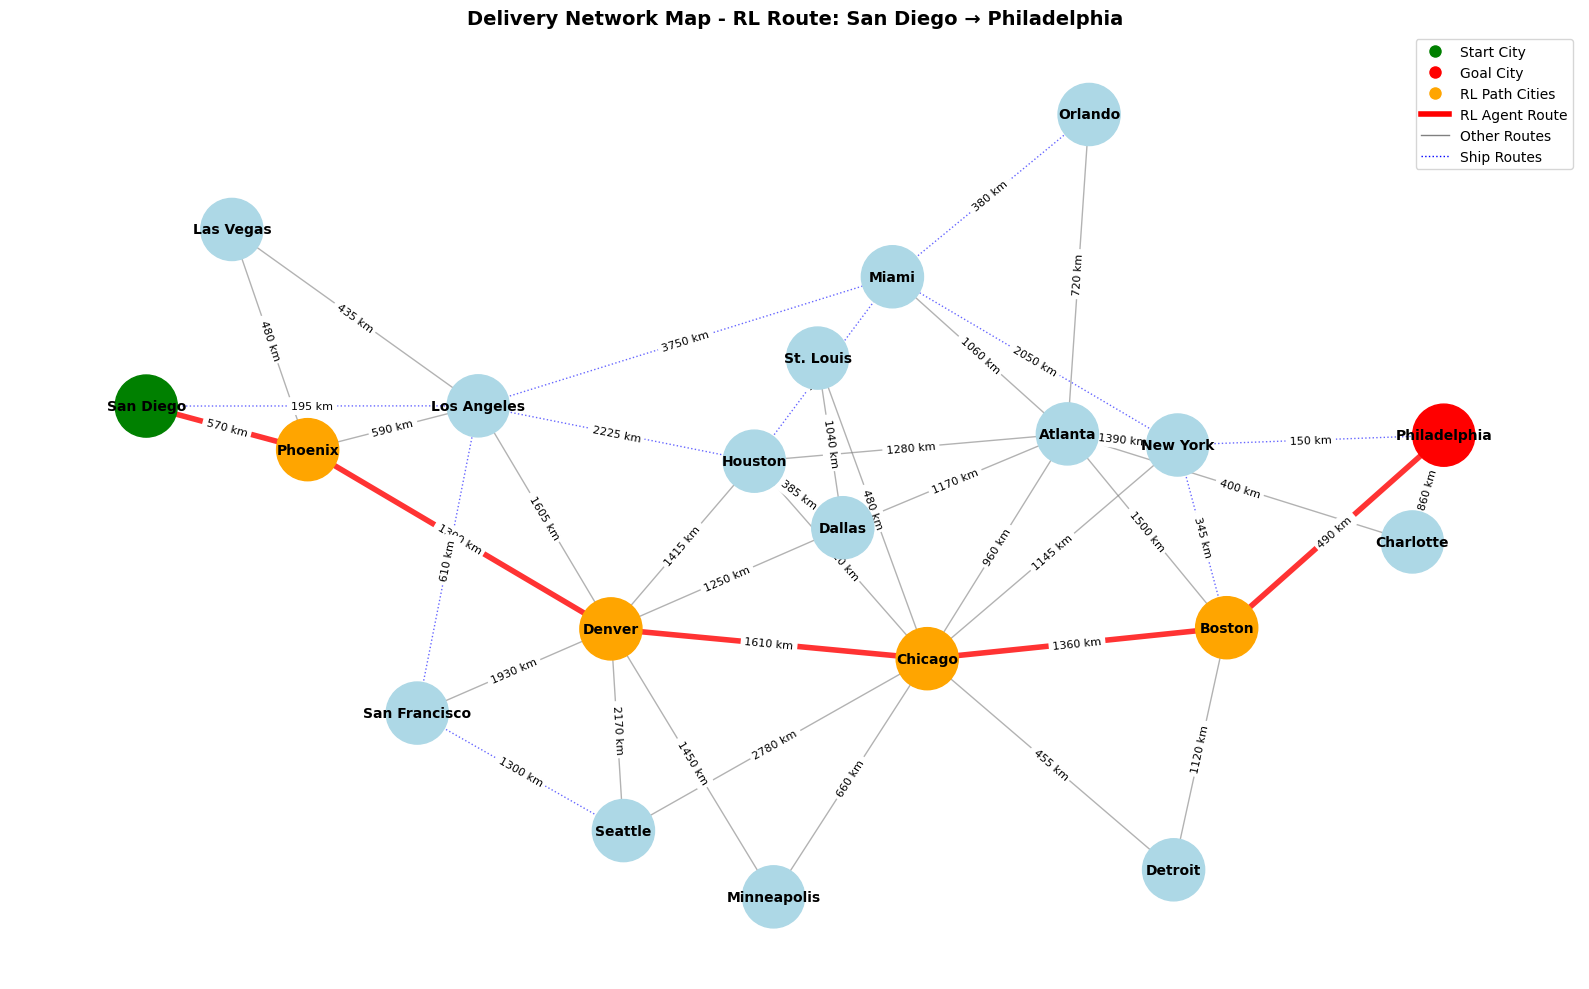

In [56]:
# Comprehensive Route Testing Code - Add to bottom of your existing file

def find_all_paths_dfs(graph, start, goal, visited=None, path=None):
    """Find all possible paths using DFS - relies on your existing loop prevention."""
    if visited is None:
        visited = set()
    if path is None:
        path = []

    visited.add(start)
    path.append(start)

    if start == goal:
        yield list(path)
    else:
        for neighbor in graph.neighbors(start):
            if neighbor not in visited:
                yield from find_all_paths_dfs(graph, neighbor, goal, visited.copy(), path.copy())

    visited.remove(start)
    path.pop()

def calculate_path_metrics(graph, path, mode_selection="cheapest"):
    """Calculate cost, time, and other metrics for a given path."""
    if len(path) < 2:
        return 0.0, 0.0, []

    total_cost = 0.0
    total_time = 0.0
    route_details = []

    for i in range(len(path) - 1):
        current_city = path[i]
        next_city = path[i + 1]

        # Get available modes for this edge
        edge_data = graph[current_city][next_city]
        available_modes = edge_data['modes']
        distance = edge_data['distance']

        # Select mode based on strategy
        if mode_selection == "cheapest":
            best_mode = min(available_modes, key=lambda m: MODES[m]['cost_per_km'])
        elif mode_selection == "fastest":
            best_mode = min(available_modes, key=lambda m: MODES[m]['hours_per_km'])
        elif mode_selection == "balanced":
            # Balance cost and time (normalize both to 0-1 scale and average)
            def balanced_score(mode):
                cost_norm = MODES[mode]['cost_per_km'] / 0.12  # Max cost per km
                time_norm = MODES[mode]['hours_per_km'] / (1.0/35)  # Max time per km
                return (cost_norm + time_norm) / 2
            best_mode = min(available_modes, key=balanced_score)
        else:
            best_mode = available_modes[0]  # Default to first available

        # Calculate cost and time for this segment
        segment_cost = distance * MODES[best_mode]['cost_per_km']
        segment_time = distance * MODES[best_mode]['hours_per_km']

        total_cost += segment_cost
        total_time += segment_time

        route_details.append({
            'from': current_city,
            'to': next_city,
            'distance': distance,
            'mode': best_mode,
            'cost': segment_cost,
            'time': segment_time
        })

    return total_cost, total_time, route_details

def comprehensive_route_test():
    """Comprehensive test of all possible routes from San Diego to Philadelphia."""
    start_city = "San Diego"
    goal_city = "Philadelphia"

    print(f"ROUTE ANALYSIS: {start_city} → {goal_city}")
    all_paths = list(find_all_paths_dfs(G, start_city, goal_city))
    print(f"Found {len(all_paths)} possible paths\n")

    # Test different optimization strategies
    strategies = ["cheapest", "fastest", "balanced"]

    for strategy in strategies:

        route_analyses = []

        for i, path in enumerate(all_paths, 1):
            cost, time, details = calculate_path_metrics(G, path, strategy)

            route_analyses.append({
                'path': path,
                'cost': cost,
                'time': time,
                'details': details,
                'hops': len(path) - 1
            })

        # Sort routes by the strategy criteria
        if strategy == "cheapest":
            route_analyses.sort(key=lambda x: x['cost'])
        elif strategy == "fastest":
            route_analyses.sort(key=lambda x: x['time'])
        else:  # balanced
            # Normalize and balance cost and time
            max_cost = max(r['cost'] for r in route_analyses)
            max_time = max(r['time'] for r in route_analyses)
            for r in route_analyses:
                cost_norm = r['cost'] / max_cost if max_cost > 0 else 0
                time_norm = r['time'] / max_time if max_time > 0 else 0
                r['balanced_score'] = (cost_norm + time_norm) / 2
            route_analyses.sort(key=lambda x: x['balanced_score'])

        # Display top 10 routes for each strategy
        print(f"\nTOP 5 ROUTES ({strategy.upper()} optimization):")
        print("-" * 80)

        for i, route in enumerate(route_analyses[:5], 1):
            path = route['path']
            cost = route['cost']
            time = route['time']
            hops = route['hops']

            # Create path string
            path_str = " → ".join(path)

            print(f"\n{i:2d}. {path_str}")
            print(f"    Cost: ${cost:7.2f} | Time: {time:6.2f}h | Hops: {hops}")

            # Show detailed segment information
            print("    Segments:")
            for detail in route['details']:
                print(f"      {detail['from']:>15} → {detail['to']:>15} "
                      f"[{detail['mode']:>6}] {detail['distance']:4.0f}km "
                      f"${detail['cost']:6.2f} {detail['time']:5.2f}h")

    # Summary comparison
    print()
    print()
    print("BEST ROUTE FROM EACH")
    print("-" * 80)


    best_routes = {}
    for strategy in strategies:
        route_analyses = []
        for path in all_paths:
            cost, time, details = calculate_path_metrics(G, path, strategy)
            route_analyses.append({
                'path': path,
                'cost': cost,
                'time': time,
                'details': details,
                'hops': len(path) - 1
            })

        if strategy == "cheapest":
            best_route = min(route_analyses, key=lambda x: x['cost'])
        elif strategy == "fastest":
            best_route = min(route_analyses, key=lambda x: x['time'])
        else:  # balanced
            max_cost = max(r['cost'] for r in route_analyses)
            max_time = max(r['time'] for r in route_analyses)
            for r in route_analyses:
                cost_norm = r['cost'] / max_cost if max_cost > 0 else 0
                time_norm = r['time'] / max_time if max_time > 0 else 0
                r['balanced_score'] = (cost_norm + time_norm) / 2
            best_route = min(route_analyses, key=lambda x: x['balanced_score'])

        best_routes[strategy] = best_route

    for strategy, route in best_routes.items():
        path_str = " → ".join(route['path'])
        print(f"\n{strategy.upper():>8}: {path_str}")
        print(f"         Cost: ${route['cost']:7.2f} | Time: {route['time']:6.2f}h | Hops: {route['hops']}")

    # Test with trained RL agent
    print()
    print()
    print("TRAINED RL AGENT RECOMMENDATION")
    print("-" * 80)


    try:
        # Use the trained agent from the main code
        if 'agent' in globals():
            rl_path, rl_cost, rl_time = agent.get_best_path(start_city, goal_city)
            rl_path_cities = [city for city, mode in rl_path]

            print(f"\nRL Agent Route: {' → '.join(rl_path_cities)}")
            print(f"Cost: ${rl_cost:.2f} | Time: {rl_time:.2f}h | Hops: {len(rl_path)-1}")

            print("\nDetailed RL Route:")
            for i, (city, mode) in enumerate(rl_path):
                if i < len(rl_path) - 1:  # Not the last city
                    next_city = rl_path[i+1][0]
                    if city in G and next_city in G[city]:
                        distance = G[city][next_city]['distance']
                        segment_cost = distance * MODES[mode]['cost_per_km']
                        segment_time = distance * MODES[mode]['hours_per_km']
                        print(f"  {city:>15} → {next_city:>15} [{mode:>6}] "
                              f"{distance:4.0f}km ${segment_cost:6.2f} {segment_time:5.2f}h")
                else:
                    print(f"  {city:>15} (DESTINATION)")
            print(f"\nGenerating map visualization with RL route highlighted...")
            visualize_graph_with_rl_route(G, rl_path_cities, start_city, goal_city)

        else:
            print("RL Agent not available - run training first!")
    except Exception as e:
        print(f"Error testing RL agent: {e}")


if __name__ == "__main__":
    comprehensive_route_test()



**Dijkstra's algorithm**

In [57]:
import heapq

class DijkstraPathfinder:
    """Dijkstra's algorithm for finding optimal paths with different optimization criteria."""

    def __init__(self, graph):
        self.graph = graph

    def get_edge_weight(self, city1, city2, optimization="distance", mode_selection="cheapest"):
        """Calculate edge weight based on optimization criteria."""
        edge_data = self.graph[city1][city2]
        distance = edge_data['distance']
        available_modes = edge_data['modes']

        # Select mode based on strategy
        if mode_selection == "cheapest":
            best_mode = min(available_modes, key=lambda m: MODES[m]['cost_per_km'])
        elif mode_selection == "fastest":
            best_mode = min(available_modes, key=lambda m: MODES[m]['hours_per_km'])
        elif mode_selection == "balanced":
            def balanced_score(mode):
                cost_norm = MODES[mode]['cost_per_km'] / 0.12
                time_norm = MODES[mode]['hours_per_km'] / (1.0/35)
                return (cost_norm + time_norm) / 2
            best_mode = min(available_modes, key=balanced_score)
        else:
            best_mode = available_modes[0]

        # Calculate weight based on optimization
        if optimization == "distance":
            return distance, best_mode
        elif optimization == "cost":
            return distance * MODES[best_mode]['cost_per_km'], best_mode
        elif optimization == "time":
            return distance * MODES[best_mode]['hours_per_km'], best_mode
        elif optimization == "balanced":
            cost = distance * MODES[best_mode]['cost_per_km']
            time = distance * MODES[best_mode]['hours_per_km']
            # Normalize and balance (using approximate max values)
            cost_norm = cost / 400  # Approximate max cost for any edge
            time_norm = time / 100  # Approximate max time for any edge
            return (cost_norm + time_norm) / 2, best_mode
        else:
            return distance, best_mode

    def dijkstra_shortest_path(self, start, goal, optimization="distance", mode_selection="cheapest"):
        """Find shortest path using Dijkstra's algorithm."""
        if start == goal:
            return [start], 0.0, []

        # Priority queue: (distance, current_node, path, modes_used)
        pq = [(0, start, [start], [])]
        visited = set()

        while pq:
            current_cost, current_node, path, modes_used = heapq.heappop(pq)

            if current_node in visited:
                continue

            visited.add(current_node)

            if current_node == goal:
                return path, current_cost, modes_used

            # Explore neighbors
            if current_node in self.graph:
                for neighbor in self.graph[current_node]:
                    if neighbor not in visited:
                        edge_weight, best_mode = self.get_edge_weight(
                            current_node, neighbor, optimization, mode_selection
                        )
                        new_cost = current_cost + edge_weight
                        new_path = path + [neighbor]
                        new_modes = modes_used + [best_mode]

                        heapq.heappush(pq, (new_cost, neighbor, new_path, new_modes))

        # No path found
        return None, float('inf'), []

    def get_path_metrics(self, path, modes_used):
        """Calculate total cost, time, and distance for a path."""
        if len(path) < 2:
            return 0.0, 0.0, 0.0

        total_cost = 0.0
        total_time = 0.0
        total_distance = 0.0

        for i in range(len(path) - 1):
            current_city = path[i]
            next_city = path[i + 1]
            mode = modes_used[i]

            edge_data = self.graph[current_city][next_city]
            distance = edge_data['distance']

            segment_cost = distance * MODES[mode]['cost_per_km']
            segment_time = distance * MODES[mode]['hours_per_km']

            total_cost += segment_cost
            total_time += segment_time
            total_distance += distance

        return total_cost, total_time, total_distance

    def debug_dijkstra_weights(graph):
        """Debug function to check if different optimizations produce different weights."""
        dijkstra = DijkstraPathfinder(graph)

        test_pairs = [("San Diego", "Los Angeles"), ("Los Angeles", "Denver")]

        print("🔍 DEBUGGING EDGE WEIGHTS:")
        for start, end in test_pairs:
            if start in graph and end in graph[start]:
                print(f"\n📍 {start} → {end}")
                print(f"Modes: {graph[start][end]['modes']}")

                for opt in ["distance", "cost", "time", "balanced"]:
                    for mode_sel in ["cheapest", "fastest", "balanced"]:
                        weight, mode = dijkstra.get_edge_weight(start, end, opt, mode_sel)
                        print(f"{opt}/{mode_sel}: {weight:.2f} using {mode}")


In [58]:
def visualize_path_comparison(graph, start_city, goal_city, rl_path_cities=None,
                            dijkstra_path=None, figsize=(20, 10)):
    """Side-by-side visualization comparing RL agent route with Dijkstra's shortest path."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Common layout for both graphs
    pos = nx.spring_layout(graph, seed=42)


    # LEFT PLOT: RL AGENT ROUTE

    ax1.set_title(f'RL Agent Route: {start_city} → {goal_city}', fontsize=14, fontweight='bold')

    # Node colors for RL plot
    node_colors_rl = []
    for node in graph.nodes():
        if node == start_city:
            node_colors_rl.append('green')
        elif node == goal_city:
            node_colors_rl.append('red')
        elif rl_path_cities and node in rl_path_cities:
            node_colors_rl.append('orange')
        else:
            node_colors_rl.append('lightblue')

    nx.draw_networkx_nodes(graph, pos, node_size=1500, node_color=node_colors_rl, ax=ax1)
    nx.draw_networkx_labels(graph, pos, font_size=8, font_weight='bold', ax=ax1)

    # RL route edges
    rl_edges = []
    if rl_path_cities and len(rl_path_cities) > 1:
        for i in range(len(rl_path_cities) - 1):
            city1, city2 = rl_path_cities[i], rl_path_cities[i + 1]
            if graph.has_edge(city1, city2):
                rl_edges.append((city1, city2))

    # Other edges
    ship_edges = []
    non_ship_edges = []
    for u, v, data in graph.edges(data=True):
        edge = (u, v)
        if edge in rl_edges or (v, u) in rl_edges:
            continue
        elif 'ship' in data['modes']:
            ship_edges.append(edge)
        else:
            non_ship_edges.append(edge)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edgelist=non_ship_edges, width=1, alpha=0.4,
                          edge_color='gray', ax=ax1)
    nx.draw_networkx_edges(graph, pos, edgelist=ship_edges, style='dotted', width=1,
                          alpha=0.4, edge_color='blue', ax=ax1)

    # Draw RL route edges in RED
    if rl_edges:
        nx.draw_networkx_edges(graph, pos, edgelist=rl_edges, width=4,
                              edge_color='red', alpha=0.8, ax=ax1)

    ax1.set_axis_off()


    # RIGHT PLOT: DIJKSTRA'S SHORTEST PATH

    ax2.set_title(f'Dijkstra Shortest Path: {start_city} → {goal_city}', fontsize=14, fontweight='bold')

    # Node colors for Dijkstra plot
    node_colors_dijkstra = []
    for node in graph.nodes():
        if node == start_city:
            node_colors_dijkstra.append('green')
        elif node == goal_city:
            node_colors_dijkstra.append('red')
        elif dijkstra_path and node in dijkstra_path:
            node_colors_dijkstra.append('pink')
        else:
            node_colors_dijkstra.append('lightblue')

    nx.draw_networkx_nodes(graph, pos, node_size=1500, node_color=node_colors_dijkstra, ax=ax2)
    nx.draw_networkx_labels(graph, pos, font_size=8, font_weight='bold', ax=ax2)

    # Dijkstra route edges
    dijkstra_edges = []
    if dijkstra_path and len(dijkstra_path) > 1:
        for i in range(len(dijkstra_path) - 1):
            city1, city2 = dijkstra_path[i], dijkstra_path[i + 1]
            if graph.has_edge(city1, city2):
                dijkstra_edges.append((city1, city2))

    # Other edges for Dijkstra plot
    ship_edges_d = []
    non_ship_edges_d = []
    for u, v, data in graph.edges(data=True):
        edge = (u, v)
        if edge in dijkstra_edges or (v, u) in dijkstra_edges:
            continue
        elif 'ship' in data['modes']:
            ship_edges_d.append(edge)
        else:
            non_ship_edges_d.append(edge)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edgelist=non_ship_edges_d, width=1, alpha=0.4,
                          edge_color='gray', ax=ax2)
    nx.draw_networkx_edges(graph, pos, edgelist=ship_edges_d, style='dotted', width=1,
                          alpha=0.4, edge_color='blue', ax=ax2)

    # Draw Dijkstra route edges in PURPLE
    if dijkstra_edges:
        nx.draw_networkx_edges(graph, pos, edgelist=dijkstra_edges, width=4,
                              edge_color='purple', alpha=0.8, ax=ax2)

    ax2.set_axis_off()

    # Common legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Start City'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Goal City'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='RL Path Cities'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='Dijkstra Path Cities'),
        Line2D([0], [0], color='red', linewidth=4, label='RL Agent Route'),
        Line2D([0], [0], color='pink', linewidth=4, label='Dijkstra Route'),
        Line2D([0], [0], color='gray', linewidth=1, label='Other Routes'),
        Line2D([0], [0], color='blue', linewidth=1, linestyle=':', label='Ship Routes')
    ]

    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)
    plt.tight_layout()
    plt.show()


In [59]:
def comprehensive_rl_dijkstra_comparison(agent, start_city="San Diego", goal_city="Philadelphia"):
    """Comprehensive comparison between RL agent and Dijkstra's algorithm."""

    print(f"COMPREHENSIVE COMPARISON: {start_city} → {goal_city}")
    print("=" * 80)

    # Initialize Dijkstra pathfinder
    dijkstra = DijkstraPathfinder(G)

    # Get RL agent path
    print("RL AGENT ANALYSIS:")
    print("-" * 40)
    rl_path, rl_cost, rl_time = agent.get_best_path(start_city, goal_city)
    rl_path_cities = [city for city, mode in rl_path]
    rl_success = rl_path_cities[-1] == goal_city if rl_path_cities else False

    print(f"Route: {' → '.join(rl_path_cities)}")
    print(f"Cost: ${rl_cost:.2f}")
    print(f"Time: {rl_time:.2f} hours")
    print(f"Hops: {len(rl_path_cities) - 1}")

    if rl_success:
        rl_total_distance = sum(G[rl_path_cities[i]][rl_path_cities[i+1]]['distance']
                               for i in range(len(rl_path_cities)-1))
        print(f"Total Distance: {rl_total_distance:.0f} km")

    # Dijkstra analysis for different optimizations
    optimization_strategies = ["distance", "cost", "time", "balanced"]
    dijkstra_results = {}

    print(f"\n DIJKSTRA'S ALGORITHM ANALYSIS:")
    print("-" * 40)


    for strategy in optimization_strategies:
        mode_selection_map = {
            "distance": "balanced",
            "cost": "cheapest",
            "time": "fastest",
            "balanced": "balanced"
        }

        path, opt_value, modes = dijkstra.dijkstra_shortest_path(
            start_city, goal_city,
            optimization=strategy,
            mode_selection=mode_selection_map[strategy]
        )
        if path:
            cost, time, distance = dijkstra.get_path_metrics(path, modes)
            dijkstra_results[strategy] = {
                'path': path,
                'modes': modes,
                'cost': cost,
                'time': time,
                'distance': distance,
                'optimization_value': opt_value,
                'hops': len(path) - 1
            }

            print(f"\n{strategy.upper()} Optimization:")
            if modes and len(modes) == len(path) - 1:
                route_with_modes = [path[0]]  # Start with first city
                for i in range(len(modes)):
                    route_with_modes.append(f"{path[i+1]}({modes[i]})")
                route_display = " → ".join(route_with_modes)
            else:
                route_display = " → ".join(path)

            print(f"  Route: {route_display}")
            print(f"  Cost: ${cost:.2f}")
            print(f"  Time: {time:.2f} hours")
            print(f"  Distance: {distance:.0f} km")
            print(f"  Hops: {len(path) - 1}")
        else:
            print(f"\n{strategy.upper()} Optimization: ❌ NO PATH FOUND")
            dijkstra_results[strategy] = None

    # Comparison table
    print(f"\n COMPARISON TABLE:")
    print("-" * 80)
    print(f"{'Method':<20} {'Success':<8} {'Cost':<10} {'Time':<10} {'Distance':<10} {'Hops':<6}")
    print("-" * 80)

    # RL Agent row
    rl_distance = sum(G[rl_path_cities[i]][rl_path_cities[i+1]]['distance']
                     for i in range(len(rl_path_cities)-1)) if rl_success else 0
    print(f"{'RL Agent':<20} {'✅' if rl_success else '❌':<8} "
          f"${rl_cost:<9.2f} {rl_time:<9.2f} {rl_distance:<9.0f} {len(rl_path_cities)-1:<6}")

    # Dijkstra rows
    for strategy in optimization_strategies:
        result = dijkstra_results[strategy]
        if result:
            print(f"{'Dijkstra-' + strategy.title():<20} {'✅':<8} "
                  f"${result['cost']:<9.2f} {result['time']:<9.2f} "
                  f"{result['distance']:<9.0f} {result['hops']:<6}")
        else:
            print(f"{'Dijkstra-' + strategy.title():<20} {'❌':<8} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'N/A':<6}")

    # Performance analysis
    print(f"\n PERFORMANCE ANALYSIS:")
    print("-" * 40)

    if rl_success and dijkstra_results['distance']:
        dijkstra_shortest = dijkstra_results['distance']

        print("Compared to Dijkstra's shortest distance path:")
        distance_diff = rl_distance - dijkstra_shortest['distance']
        cost_diff = rl_cost - dijkstra_shortest['cost']
        time_diff = rl_time - dijkstra_shortest['time']

        print(f"  Distance: {'+' if distance_diff > 0 else ''}{distance_diff:.0f} km "
              f"({'+' if distance_diff > 0 else ''}{(distance_diff/dijkstra_shortest['distance']*100):.1f}%)")
        print(f"  Cost: {'+' if cost_diff > 0 else ''}${cost_diff:.2f} "
              f"({'+' if cost_diff > 0 else ''}{(cost_diff/dijkstra_shortest['cost']*100):.1f}%)")
        print(f"  Time: {'+' if time_diff > 0 else ''}{time_diff:.2f} hours "
              f"({'+' if time_diff > 0 else ''}{(time_diff/dijkstra_shortest['time']*100):.1f}%)")

    # Generate visualizations
    print(f"\n GENERATING VISUALIZATIONS...")

    # Choose best Dijkstra path for visualization (shortest distance)
    dijkstra_path_for_viz = dijkstra_results['distance']['path'] if dijkstra_results['distance'] else None

    visualize_path_comparison(
        graph=G,
        start_city=start_city,
        goal_city=goal_city,
        rl_path_cities=rl_path_cities if rl_success else None,
        dijkstra_path=dijkstra_path_for_viz
    )

    return {
        'rl_result': {
            'path': rl_path_cities,
            'cost': rl_cost,
            'time': rl_time,
            'distance': rl_distance if rl_success else 0,
            'success': rl_success
        },
        'dijkstra_results': dijkstra_results
    }



Testing Dijkstra vs RL Agent Comparison...
COMPREHENSIVE COMPARISON: San Diego → Philadelphia
RL AGENT ANALYSIS:
----------------------------------------
Route: San Diego → Phoenix → Denver → Chicago → Boston → Philadelphia
Cost: $491.40
Time: 43.70 hours
Hops: 5
Total Distance: 5330 km

 DIJKSTRA'S ALGORITHM ANALYSIS:
----------------------------------------

DISTANCE Optimization:
  Route: San Diego → Los Angeles(train) → Denver(train) → Chicago(train) → New York(train) → Philadelphia(train)
  Cost: $282.30
  Time: 39.21 hours
  Distance: 4705 km
  Hops: 5

COST Optimization:
  Route: San Diego → Los Angeles(ship) → Houston(ship) → Atlanta(train) → Charlotte(train) → Philadelphia(ship)
  Cost: $232.00
  Time: 107.71 hours
  Distance: 4960 km
  Hops: 5

TIME Optimization:
  Route: San Diego → Los Angeles(flight) → Denver(flight) → Chicago(flight) → New York(flight) → Philadelphia(flight)
  Cost: $564.60
  Time: 6.27 hours
  Distance: 4705 km
  Hops: 5

BALANCED Optimization:
  Route: 

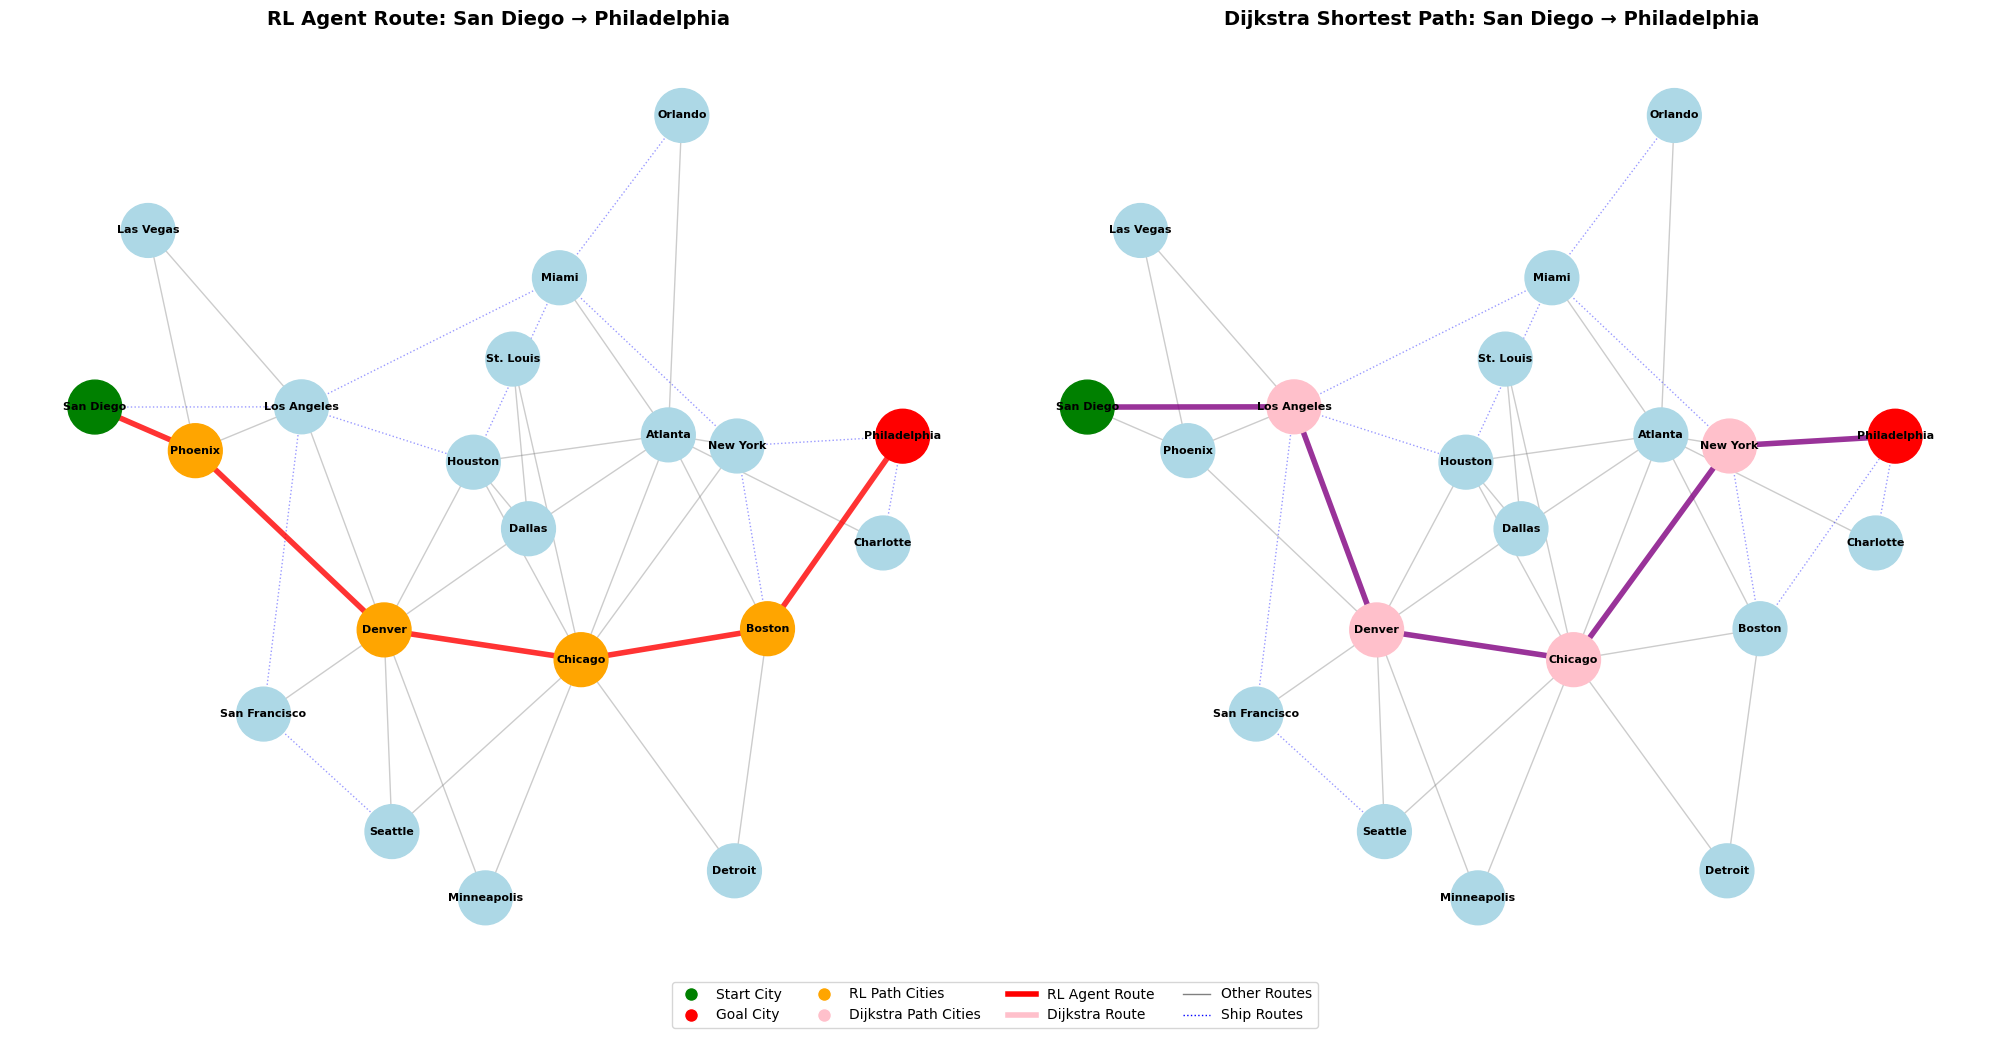

In [60]:
def test_dijkstra_comparison():
    """Test function to run the Dijkstra comparison after training."""
    print("Testing Dijkstra vs RL Agent Comparison...")

    # Make sure you have a trained agent
    if 'agent' not in globals():
        print("❌ No trained agent found! Run training first:")
        print("   agent, env, rewards = quick_test_fixed()")
        return

    # Run comparison
    result = comprehensive_rl_dijkstra_comparison(agent, "San Diego", "Philadelphia")

test_dijkstra_comparison()